Imagem original


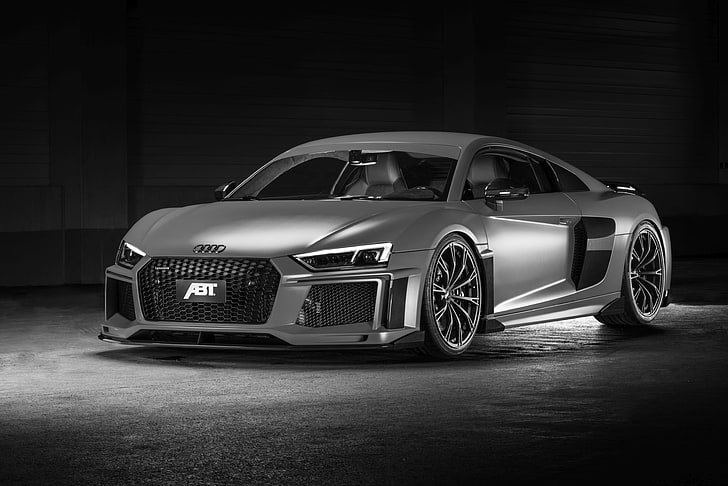

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.util import random_noise
import math

#Funcao que cria o filtro Gaussiano
def gauss_create(sigma=1, size_x=3, size_y=3):
    '''
    Create normal (gaussian) distribuiton
    '''
    x, y = np.meshgrid(np.linspace(-1,1,size_x), np.linspace(-1,1,size_y))
    calc = 1/((2*np.pi*(sigma**2)))
    exp = np.exp(-(((x**2) + (y**2))/(2*(sigma**2))))

    return exp*calc

#Codigo para calcular as metricas de qualidade
#MSE - Mean Square Error
#Quanto mais próximo do zero, mais iguais as imagens são
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

#PSNR - Peak Signal to Noise Error
#Medido em dB
#Quanto maior melhor (considerável bom >= 20 dB)
def psnr(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): #indica que sao totalmente iguais
		return 100
	max_pixel = 255.0
	psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
	return psnr

#RMSE - Root-Mean Square Error
#Indica o erro padronizado, quanto maior pior
def rmse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    err = math.sqrt(err)
    return err

def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

#Funcao que faz a convolucao para o sobel
def conv2d_sharpening(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            #calcula kernel
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.float32)

#Funcao que faz a convolucao
def conv2d(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    #print(padded_img)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.array(output, dtype=np.uint8)

#funcao que cria a mascara de passada alta ideal ou gaussiana
def createPA(shape, center, radius, lpType=2, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows:1, 0:cols:1]
    c -= center[0]
    r -= center[1]
    d = np.power(c, 2.0) + np.power(r, 2.0)
    lpFilter_matrix = np.zeros(shape, np.float32)
    if lpType == 0:  # Ideal high pass filter
        lpFilter = np.copy(d)
        lpFilter[lpFilter < pow(radius, 2.0)] = 0
        lpFilter[lpFilter >= pow(radius, 2.0)] = 1
    elif lpType == 1: # Gaussian Highpass Filter
        lpFilter = 1.0 - np.exp(-d/(2*pow(radius, 2.0)))
    lpFilter_matrix[:, :, 0] = lpFilter
    lpFilter_matrix[:, :, 1] = lpFilter
    return lpFilter_matrix

#Funcao que cria o Filtro Passa Baixa Gaussiano
def createPB(shape, center, radius, lpType=2, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows:1, 0:cols:1]
    c -= center[0]
    r -= center[1]
    d = np.power(c, 2.0) + np.power(r, 2.0)
    lpFilter_matrix = np.zeros(shape, np.float32)
    if lpType == 0:  # ideal low-pass filter
        lpFilter = np.copy(d)
        lpFilter[lpFilter < pow(radius, 2.0)] = 1
        lpFilter[lpFilter >= pow(radius, 2.0)] = 0
    elif lpType == 1: #Butterworth low-pass filter
        lpFilter = 1.0 / (1 + np.power(np.sqrt(d)/radius, 2*n))
    elif lpType == 2: # Gaussian low pass filter
        lpFilter = np.exp(-d/(2*pow(radius, 2.0)))
    lpFilter_matrix[:, :, 0] = lpFilter
    lpFilter_matrix[:, :, 1] = lpFilter
    return lpFilter_matrix

#Abrir a imagem
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/audir8.jpg',0)
print("Imagem original")
cv2_imshow(img)
cv2.imwrite('imgOriginalEscalaCinza.png', img)

image_f32 = np.float32(img) # convert from uint8 into float32
dft = cv2.dft(image_f32, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

magnitude_spectrum = np.abs(magnitude_spectrum)
magnitude_spectrum -= magnitude_spectrum.min()
magnitude_spectrum = magnitude_spectrum*255 / magnitude_spectrum.max()
magnitude_spectrum = magnitude_spectrum.astype(np.uint8)

nrows, ncols = dft_shift.shape[:2]
real = np.power(dft_shift[:, :, 0], 2.0)
imaginary = np.power(dft_shift[:, :, 1], 2.0)
amplitude = np.sqrt(real+imaginary)
minValue, maxValue, minLoc, maxLoc = cv2.minMaxLoc(amplitude)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


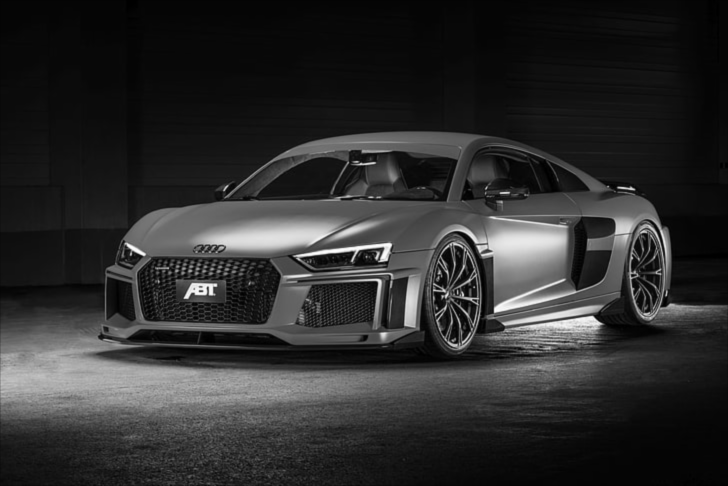

True

In [ ]:
#Aplicando o filtro gaussiano
gaus_3x3 = gauss_create(sigma=0.6, size_x=3, size_y=3)
img_gauss = conv2d(img, gaus_3x3)
cv2_imshow(img_gauss)
cv2.imwrite('gauss.png', img_gauss)

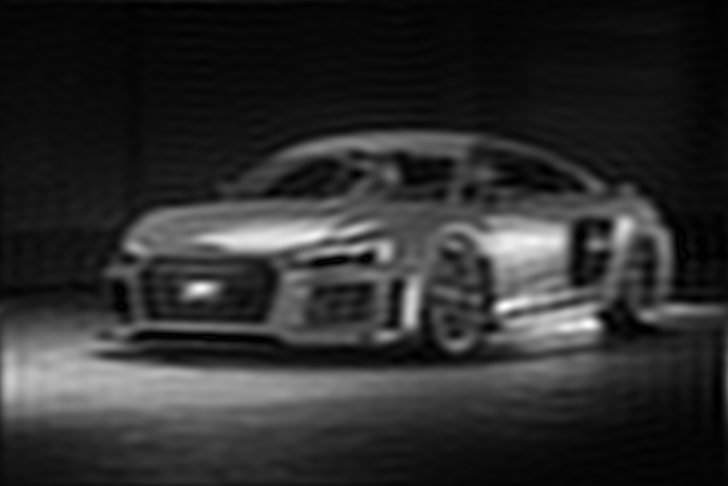

True

In [ ]:
#Criando o PB ideal
maskPB = createPB(dft_shift.shape, center=maxLoc, radius=35, lpType=0, n=2)

filtered_freq = dft_shift*maskPB
f_ishift = np.fft.ifftshift(filtered_freq)  #inversa da fft
img_back = cv2.idft(f_ishift)        #inversa da dft
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])  #recuperando a imagem capturando a magnitude (intesidade)

img_back = np.array(img_back, dtype=np.float32)

#usar para normalizar a imagem e poder exibir com a imshow() da opencv
filtered_imgPB = np.abs(img_back)
filtered_imgPB -= filtered_imgPB.min()
filtered_imgPB = filtered_imgPB*255 / filtered_imgPB.max()
filtered_imgPB = filtered_imgPB.astype(np.uint8)

#plotando com a OpenCV
cv2_imshow(filtered_imgPB)
cv2.imwrite('pbideal.png', filtered_imgPB)

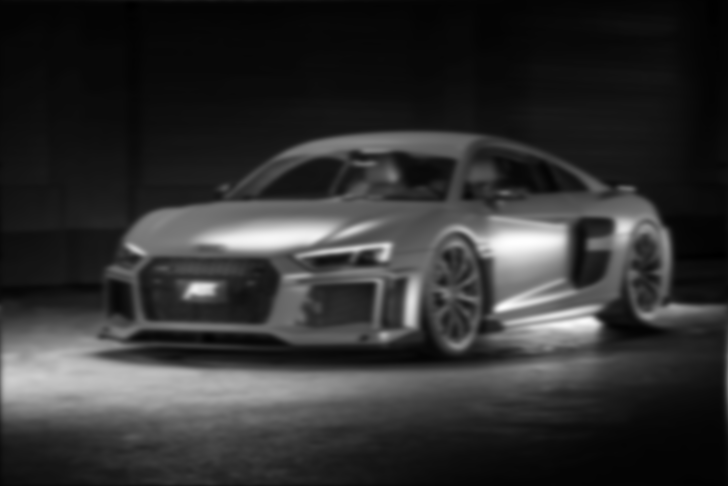

True

In [ ]:
#Criando o PB gaussiano
maskPBG = createPB(dft_shift.shape, center=maxLoc, radius=35, lpType=2, n=2)

filtered_freq = dft_shift*maskPBG
f_ishift = np.fft.ifftshift(filtered_freq)  #inversa da fft
img_back = cv2.idft(f_ishift)        #inversa da dft
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])  #recuperando a imagem capturando a magnitude (intesidade)

img_back = np.array(img_back, dtype=np.float32)

#usar para normalizar a imagem e poder exibir com a imshow() da opencv
filtered_imgPBG = np.abs(img_back)
filtered_imgPBG -= filtered_imgPBG.min()
filtered_imgPBG = filtered_imgPBG*255 / filtered_imgPBG.max()
filtered_imgPBG = filtered_imgPBG.astype(np.uint8)

#plotando com a OpenCV
cv2_imshow(filtered_imgPBG)
cv2.imwrite('pbgaussiano.png', filtered_imgPBG)

In [ ]:
#Comparacoes utilizando as metricas PSNR, RMSE e MSE entre Filtro espacial de esmaecimento gaussiano x Filtro passa-baixa ideal e gaussiano
#Metricas com Passa Baixa Ideal e Gaussiano Espacial
mse_pb_ideal = mse(filtered_imgPB, img_gauss)
psnr_pb_ideal = psnr(filtered_imgPB, img_gauss)
rmse_pb_ideal = rmse(filtered_imgPB, img_gauss)
print("MSE entre Passa Baixa Ideal e Gaussiano Espacial: ", mse_pb_ideal)
print("PSNR entre Passa Baixa Ideal e Gaussiano: ", psnr_pb_ideal)
print("RMSE entre Passa Baixa Ideal e Gaussiano: ", rmse_pb_ideal, "\n")
#Metricas com Passa Baixa Gaussiano e Gaussiano Espacial
mse_pb_gauss = mse(filtered_imgPBG, img_gauss)
psnr_pb_gauss = psnr(filtered_imgPBG, img_gauss)
rmse_pb_gauss = rmse(filtered_imgPBG, img_gauss)
print("MSE entre Passa Baixa Gaussiano e Gaussiano Espacial: ", mse_pb_gauss)
print("PSNR entre Passa Baixa Gaussiano e Gaussiano Espacial: ", psnr_pb_gauss)
print("RMSE entre Passa Baixa Gaussiano e Gaussiano Espacial: ", rmse_pb_gauss)

MSE entre Passa Baixa Ideal e Gaussiano Espacial:  223.8921505449283
PSNR entre Passa Baixa Ideal e Gaussiano:  32.63368135254752
RMSE entre Passa Baixa Ideal e Gaussiano:  14.963026115894081 

MSE entre Passa Baixa Gaussiano e Gaussiano Espacial:  185.26797019852575
PSNR entre Passa Baixa Gaussiano e Gaussiano Espacial:  32.19281044523215
RMSE entre Passa Baixa Gaussiano e Gaussiano Espacial:  13.611317724545472


Imagem original com Sobel


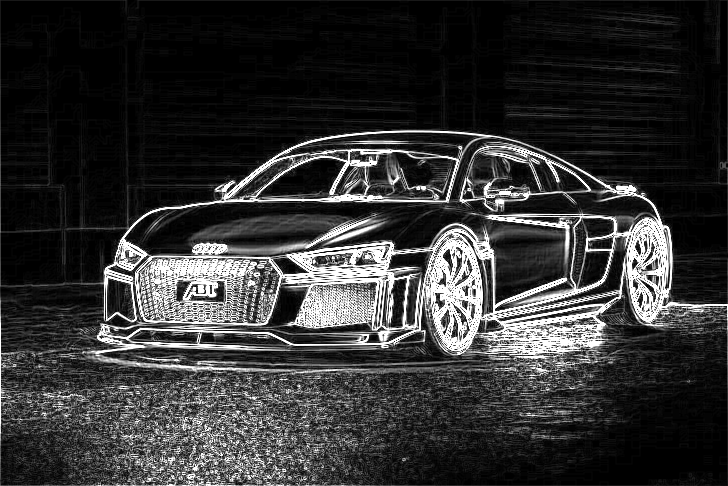

True

In [ ]:
#Criando os kernels do sobel
kernel_sobel_1 = np.array(([-1,-2,-1],[0,0,0],[1,2,1]))
kernel_sobel_2 = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))
#Aplicando o sobel em uma img
img_sobel_1 = conv2d_sharpening(img, kernel_sobel_1)
img_sobel_2 = conv2d_sharpening(img, kernel_sobel_2)
img_sobel = np.abs(img_sobel_1)+np.abs(img_sobel_2)
print("Imagem original com Sobel")
cv2_imshow(img_sobel)
cv2.imwrite('imgSobel.png', img_sobel)

Imagem Passa Alta Gaussiano


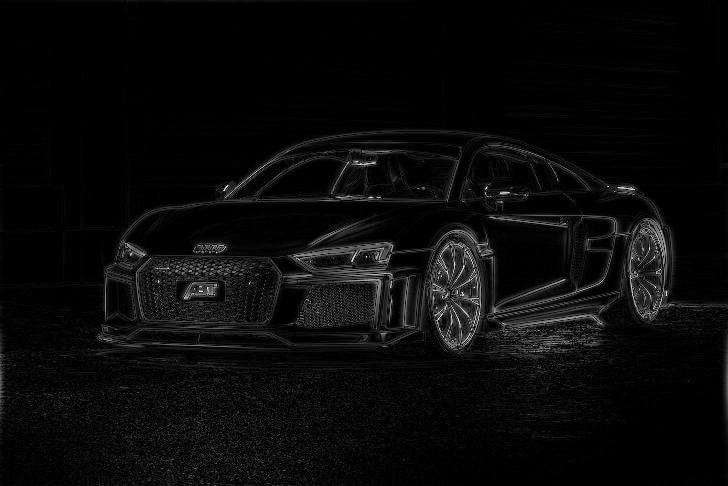

True

In [ ]:
#Aplicando o filtro Passa Alta Gaussiano
maskPA = createPA(dft_shift.shape, center=maxLoc, radius=35, lpType=1, n=1)

filtered_freq = dft_shift*maskPA
f_ishift = np.fft.ifftshift(filtered_freq)  #inversa da fft
img_back = cv2.idft(f_ishift)        #inversa da dft
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])  #recuperando a imagem capturando a magnitude (intesidade)


img_back = np.array(img_back, dtype=np.float32)

#usar para normalizar a imagem e poder exibir com a imshow() da opencv
filtered_img_pa_gauss = np.abs(img_back)
filtered_img_pa_gauss -= filtered_img_pa_gauss.min()
filtered_img_pa_gauss = filtered_img_pa_gauss*255 / filtered_img_pa_gauss.max()
filtered_img_pa_gauss = filtered_img_pa_gauss.astype(np.uint8)

#plotando com a OpenCV
print("Imagem Passa Alta Gaussiano")
cv2_imshow(filtered_img_pa_gauss)
cv2.imwrite('imgPassaAltaGaussiano.png', filtered_img_pa_gauss)

Imagem Passa Alta Ideal


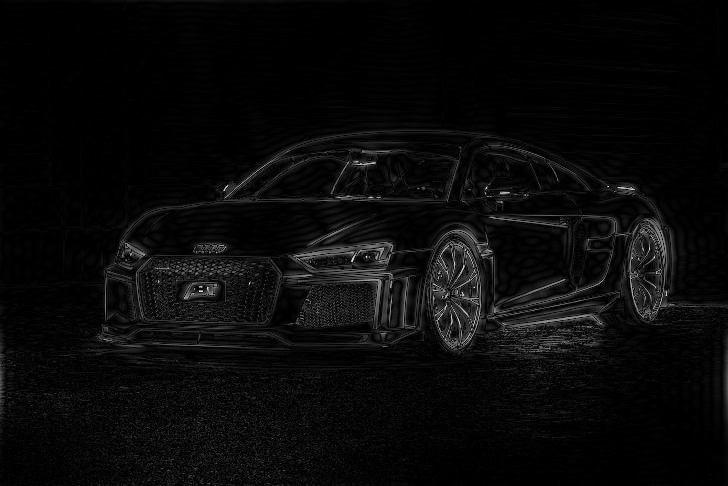

True

In [ ]:
#Aplicando o filtro Passa Alta Ideal
maskPA = createPA(dft_shift.shape, center=maxLoc, radius=35, lpType=0, n=1)

filtered_freq = dft_shift*maskPA
f_ishift = np.fft.ifftshift(filtered_freq)  #inversa da fft
img_back = cv2.idft(f_ishift)        #inversa da dft
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])  #recuperando a imagem capturando a magnitude (intesidade)


img_back = np.array(img_back, dtype=np.float32)

#usar para normalizar a imagem e poder exibir com a imshow() da opencv
filtered_img_pa_ideal = np.abs(img_back)
filtered_img_pa_ideal -= filtered_img_pa_ideal.min()
filtered_img_pa_ideal = filtered_img_pa_ideal*255 / filtered_img_pa_ideal.max()
filtered_img_pa_ideal = filtered_img_pa_ideal.astype(np.uint8)

#plotando com a OpenCV
print("Imagem Passa Alta Ideal")
cv2_imshow(filtered_img_pa_ideal)
cv2.imwrite('imgPassaAltaIdeal.png', filtered_img_pa_ideal)

Imagem com Canny


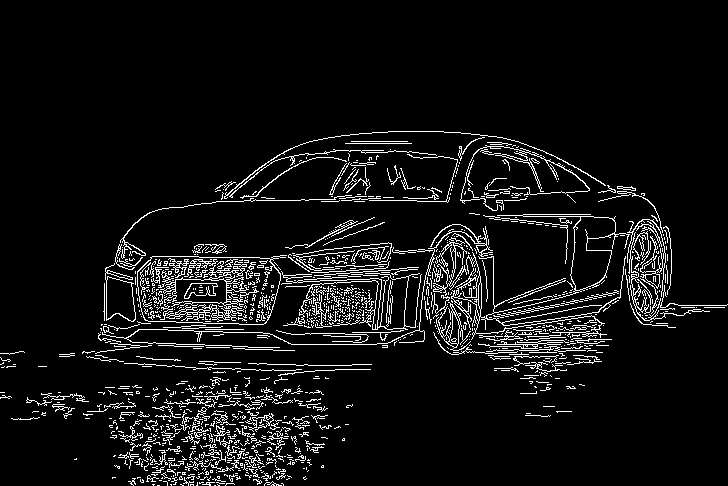

True

In [ ]:
#Aplicando o Canny
img_canny = cv2.Canny(img,100,200)
print("Imagem com Canny")
cv2_imshow(img_canny)
cv2.imwrite('imgCanny.png', img_canny)

In [ ]:
#Comparacoes utilizando as metricas PSNR, RMSE e MSE entre Sobel com Canny, passa-alta ideal com Canny e passa-alta gaussiano com Canny
#Metricas com o Sobel x Canny
mse_sobel = mse(img_sobel, img_canny)
psnr_sobel = psnr(img_sobel, img_canny)
rmse_sobel = rmse(img_sobel, img_canny)
print("MSE entre Sobel e Canny: ", mse_sobel)
print("PSNR entre Sobel e Canny: ", psnr_sobel)
print("RMSE entre Sobel e Canny: ", rmse_sobel, "\n")
#Metricas com o passa-alta ideal x Canny
mse_pa_ideal = mse(filtered_img_pa_ideal, img_canny)
psnr_pa_ideal = psnr(filtered_img_pa_ideal, img_canny)
rmse_pa_ideal = rmse(filtered_img_pa_ideal, img_canny)
print("MSE entre Passa Alta Ideal e Canny: ", mse_pa_ideal)
print("PSNR entre Passa Alta Ideal e Canny: ", psnr_pa_ideal)
print("RMSE entre Passa Alta Ideal e Canny: ", rmse_pa_ideal, "\n")
#Metricas com o passa-alta gaussiano x Canny
mse_pa_gauss = mse(filtered_img_pa_gauss, img_canny)
psnr_pa_gauss = psnr(filtered_img_pa_gauss, img_canny)
rmse_pa_gauss = rmse(filtered_img_pa_gauss, img_canny)
print("MSE entre Passa Alta Gaussiano e Canny: ", mse_pa_gauss)
print("PSNR entre Passa Alta Gaussiano e Canny: ", psnr_pa_gauss)
print("RMSE entre Passa Alta Gaussiano e Canny: ", rmse_pa_gauss)

MSE entre Sobel e Canny:  12989.6865785963
PSNR entre Sobel e Canny:  6.994817556790979
RMSE entre Sobel e Canny:  113.97230619144416 

MSE entre Passa Alta Ideal e Canny:  4114.578836544114
PSNR entre Passa Alta Ideal e Canny:  32.18263782046719
RMSE entre Passa Alta Ideal e Canny:  64.14498294133466 

MSE entre Passa Alta Gaussiano e Canny:  4102.476326142993
PSNR entre Passa Alta Gaussiano e Canny:  32.50844267160636
RMSE entre Passa Alta Gaussiano e Canny:  64.05057631390207
